In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from math import log2
def cost_basic(K: int, N: int, B: int, L: int, J: int) -> int:
    return B*N*(log2(J) + 1) + (J*L>K) * B*J*L*(log2(K) + 1)

In [4]:
df = pd.concat([pd.read_json(f"out/gpu_{i}.jsonl", lines=True) for i in range(8)], ignore_index=True)

In [5]:
df.head()

,name,task,model,sparsity,execution,code_changes,parameters,model_config,results,count,prefill_length,match,duration
0,test-bucket-topk,"{'name': 'squad', 'shots': 1, 'samples': 4000,...",meta-llama/Meta-Llama-3-8B,"{'name': 'ann', 'k': 128, 'local_k': 32, 'real...","{'device': 'cuda:0', 'dtype': 'float16', 'batc...","{'ann-local-token-for-free': True, 'repetition...",8030261248,"{'vocab_size': 128256, 'max_position_embedding...","[{'id': '5711607f2419e314009555cf', 'output': ...",4000,1408.9925,0.81050,3265.794863
1,test-bucket-topk,"{'name': 'squad', 'shots': 1, 'samples': 4000,...",meta-llama/Meta-Llama-3-8B,"{'name': 'ann', 'k': 128, 'local_k': 32, 'real...","{'device': 'cuda:0', 'dtype': 'float16', 'batc...","{'ann-local-token-for-free': True, 'repetition...",8030261248,"{'vocab_size': 128256, 'max_position_embedding...","[{'id': '5711607f2419e314009555cf', 'output': ...",4000,1408.9925,0.81000,3643.755743
2,test-bucket-topk,"{'name': 'squad', 'shots': 1, 'samples': 4000,...",meta-llama/Meta-Llama-3-8B,"{'name': 'ann', 'k': 128, 'local_k': 32, 'real...","{'device': 'cuda:0', 'dtype': 'float16', 'batc...","{'ann-local-token-for-free': True, 'repetition...",8030261248,"{'vocab_size': 128256, 'max_position_embedding...","[{'id': '5711607f2419e314009555cf', 'output': ...",4000,1408.9925,0.81025,3648.549870
3,test-bucket-topk,"{'name': 'squad', 'shots': 1, 'samples': 4000,...",meta-llama/Meta-Llama-3-8B,"{'name': 'ann', 'k': 128, 'local_k': 32, 'real...","{'device': 'cuda:0', 'dtype': 'float16', 'batc...","{'ann-local-token-for-free': True, 'repetition...",8030261248,"{'vocab_size': 128256, 'max_position_embedding...","[{'id': '5711607f2419e314009555cf', 'output': ...",4000,1408.9925,0.80925,3848.676115
4,test-bucket-topk,"{'name': 'squad', 'shots': 1, 'samples': 4000,...",meta-llama/Meta-Llama-3-8B,"{'name': 'ann', 'k': 128, 'local_k': 32, 'real...","{'device': 'cuda:0', 'dtype': 'float16', 'batc...","{'ann-local-token-for-free': True, 'repetition...",8030261248,"{'vocab_size': 128256, 'max_position_embedding...","[{'id': '5711607f2419e314009555cf', 'output': ...",4000,1408.9925,0.81050,3802.179857


In [6]:
df = (
    df.drop(
        [
            "name",
            "model",
            "execution",
            "code_changes",
            "parameters",
            "model_config",
            "results",
            "count",
            "duration",
        ],
        axis=1,
    )
    .pipe(
        lambda d: d.assign(task_name=d["task"].apply(lambda x: x.get("name"))).drop(
            "task", axis=1
        )
    )
    .pipe(
        lambda d: d.join(pd.json_normalize(d["sparsity"])).drop(
            ["sparsity", "name", "reallocate_to_mean_value", "score", "rank"], axis=1
        )
    )
    .pipe(lambda d: d.assign(score=d["match"]).drop(["match"], axis=1))
    .pipe(lambda d: d.assign(k=d["k"] - d["local_k"]).drop(columns="local_k"))
    .sort_values("topk_k_per_bucket")
    .reset_index(drop=True)
)
df["cost"] = df.apply(
    lambda row: cost_basic(
        row["k"],
        row["prefill_length"],
        1,
        row["k"] * row["topk_k_mult"] // row["topk_k_per_bucket"],
        row["topk_k_per_bucket"],
    ),
    axis=1,
)

In [7]:
df

,prefill_length,task_name,k,bucket_topk,topk_k_per_bucket,topk_interleaved,topk_k_mult,score,cost
0,1408.9925,squad,96,True,1.0,False,1.0,0.75675,1408.992500
1,1408.9925,squad,96,True,1.0,True,1.0,0.80000,1408.992500
2,1408.9925,squad,96,True,1.0,False,2.0,0.77275,2865.305300
3,1408.9925,squad,96,True,1.0,True,2.0,0.80625,2865.305300
4,1408.9925,squad,96,True,1.0,True,4.0,0.80775,4321.618100
5,1408.9925,squad,96,True,1.0,False,4.0,0.79075,4321.618100
6,1408.9925,squad,96,True,1.0,False,8.0,0.80375,7234.243701
7,1408.9925,squad,96,True,1.0,True,8.0,0.81025,7234.243701
8,1408.9925,squad,96,True,2.0,True,2.0,0.81000,4274.297800
9,1408.9925,squad,96,True,2.0,False,2.0,0.79700,4274.297800


In [8]:
df.to_json("sparq_v2.jsonl", orient="records", lines=True)

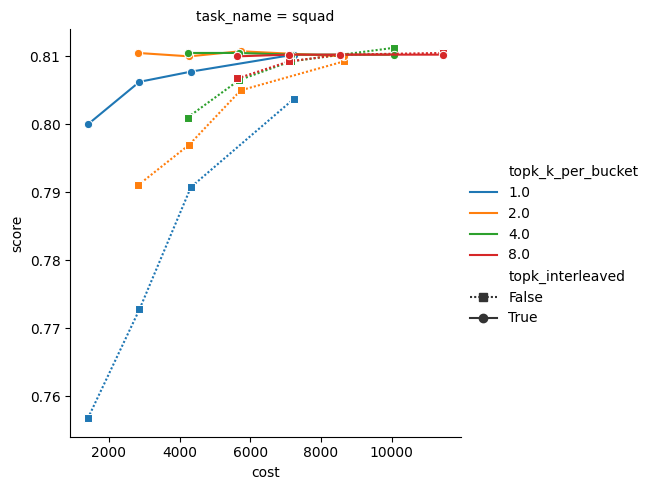

In [9]:
# Convert to categorical for seaborn
df["topk_k_per_bucket"] = df["topk_k_per_bucket"].map(lambda x: str(x))

sns.relplot(
    df[df["bucket_topk"] == True],
    x="cost",
    y="score",
    col="task_name",
    hue="topk_k_per_bucket",
    style="topk_interleaved",
    kind="line",
    dashes={True: "", False: (1, 1)},
    markers={True: "o", False: "s"},
    facet_kws=dict(sharey=False),
)
plt.show()